# Notebook for training a Gaussian Process for the Elastic Moduli from Recipe 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from sklearn.model_selection import train_test_split
from ml.neural_net import NN, NN_co2
from ml.neural_net import hyp_param_opt
from ml.validate import evaluate_predictions
from ml.validate import plot_true_vs_predicted, plot_model1_vs_model2, plot_loss
from ml.opt import opt, opt_gp, opt_ismo
from util.time import measure_and_plot_time
from util.normalization import minmax_normalize

import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore")
import pickle

2024-05-26 06:49:53.623792: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 06:49:54.498298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 06:49:54.498348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 06:49:54.651153: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 06:49:54.967029: I tensorflow/core/platform/cpu_feature_guar

In [2]:
name = '_LHS_1000_'

In [3]:
########################################################################################
#
#                   LOAD DATA
#
########################################################################################
#file_path = 'data_repo/'
file_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/InputData/'


X = pd.read_csv(file_path+ 'recipe_data'+name+'.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'elastic_moduli'+name+'.csv')

train_input_gp, test_input_gp, train_elastic_gp, test_elastic_gp = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
train_input_gp = train_input_gp.reset_index(drop=True)
test_input_gp = test_input_gp.reset_index(drop=True)

train_elastic_gp = train_elastic_gp.reset_index(drop=True)
test_elastic_gp =test_elastic_gp.reset_index(drop=True)

In [100]:
########################################################################################
#
#                    GAUSSIAN PROCESS
#
########################################################################################
#kernel = 1**2 * Matern(length_scale=2, nu=1.6)
#kernel = 1**2 * RBF(length_scale=1.5)
#kernel = 1**2 * RationalQuadratic(length_scale=1, alpha=0.8)
kernel = 1**2 * Matern(length_scale=2, nu=1.6) + WhiteKernel(noise_level=1)


gpg = GaussianProcessRegressor(kernel).fit(train_input_gp, train_elastic_gp)
print('=====================================================')
print('The score for the Gaussian Process for hydration on the training set is: ', gpg.score(train_input_gp, train_elastic_gp))
print('The mean square error on the training set is: ', np.mean((gpg.predict(train_input_gp)-train_elastic_gp)**2))


The score for the Gaussian Process for hydration on the training set is:  0.005564597610017874
The mean square error on the training set is:  89.10860038031473


In [101]:
model_path =  '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/Output/Models/'
from joblib import dump, load
dump(gpg, model_path + 'GPG'+name+'.joblib') 

['/mnt/disk1/projects/Cement/02-Software_and_Models/Models/Output/Models/GPG_LHS_1000_.joblib']

In [102]:
########################################################################################
#
#                    Validation of the GP
#
########################################################################################
#Evaluation of the GP
predicted_values = gpg.predict(test_input_gp)
model_perf = evaluate_predictions(test_elastic_gp, predicted_values)

model_perf =model_perf.transpose()
#Plot true vs predicted
#plot_true_vs_predicted(test_elastic_gp, predicted_values, 'elasticity_gp')
model_perf = model_perf.rename(columns = {0:'K',1:'G',2:'E',3:'P'})

model_perf['mean']=model_perf.mean(axis  =1)
model_perf
model_perf.to_csv(model_path + 'GPG_performance'+name+'.csv')

In [103]:
print('The score for the Gaussian Process for hydration on the test set is: ', gpg.score(test_input_gp, test_elastic_gp))
print('The mean square error on the test set is: ', np.mean((predicted_values-test_elastic_gp)**2))

The score for the Gaussian Process for hydration on the test set is:  -0.013730180554499483
The mean square error on the test set is:  81.06618156335813


In [104]:
predicted_values = pd.DataFrame(predicted_values, columns = ['K','G','E','P'])
predicted_values

K          G          E         P
0    28.001318  11.356201  29.973067  0.313645
1    27.734012  11.263640  29.724900  0.313675
2    27.583922  11.207811  29.576365  0.313709
3    27.727927  11.264734  29.726408  0.313584
4    27.767433  11.275919  29.757283  0.313620
..         ...        ...        ...       ...
184  27.807300  11.285803  29.785354  0.313694
185  27.731365  11.258449  29.712208  0.313694
186  27.845469  11.297580  29.817358  0.313702
187  27.745033  11.263240  29.725150  0.313706
188  27.878622  11.307637  29.845112  0.313761

[189 rows x 4 columns]

K
0 0
G
1 0
E
0 1
P
1 1


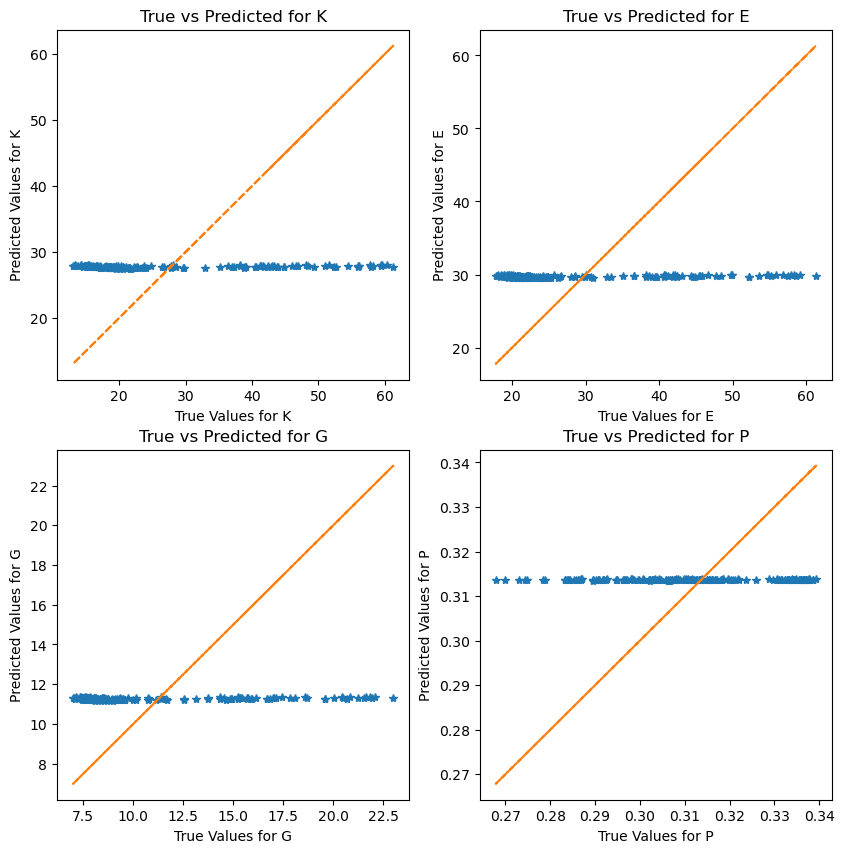

In [105]:
true = test_elastic_gp
pred = predicted_values
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
i=0
j=0
for col in predicted_values.columns: 
    ax = axes[i,j]
    print(col)
    ax.plot(true[col], pred[col],'*')
    ax.plot(true[col], true[col],'--')
    ax.set_xlabel(f'True Values for {col}')
    ax.set_ylabel(f'Predicted Values for {col}')
    ax.set_title(f'True vs Predicted for {col}')
    print(i,j)
    i=i+1
    if i==2:
        i=0
        j=1
plt.savefig(model_path + 'GPG_pred'+name+'.png')

In [88]:
predicted_values

K    G    E    P
0    0.0  0.0  0.0  0.0
1    0.0  0.0  0.0  0.0
2    0.0  0.0  0.0  0.0
3    0.0  0.0  0.0  0.0
4    0.0  0.0  0.0  0.0
..   ...  ...  ...  ...
184  0.0  0.0  0.0  0.0
185  0.0  0.0  0.0  0.0
186  0.0  0.0  0.0  0.0
187  0.0  0.0  0.0  0.0
188  0.0  0.0  0.0  0.0

[189 rows x 4 columns]